In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('DDIset.csv')

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np


# Clean the dataset (if necessary)
df['X1'] = df['X1'].fillna('')
df['X2'] = df['X2'].fillna('')

# Use existing fingerprint features directly
X = df.drop(columns=['ID1', 'ID2', 'Interaction', 'Side Effect Name', 'X1', 'X2'])  # Drop non-feature columns
y = df['Interaction']

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Now X_train, X_test, y_train, y_test are ready for model training and evaluation

In [4]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

[LightGBM] [Info] Number of positive: 50861, number of negative: 49338
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.174288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12162
[LightGBM] [Info] Number of data points in the train set: 100199, number of used features: 4096
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507600 -> initscore=0.030402
[LightGBM] [Info] Start training from score 0.030402
Accuracy: 0.8621556886227545
AUC: 0.9397170574995842


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Define the new molecule (ID1) APIXABAN
new_smiles = "COC1=CC=C(C=C1)N2C3=C(CCN(C3=O)C4=CC=C(C=C4)N5CCCCC5=O)C(=N2)C(=O)N"
new_mol = Chem.MolFromSmiles(new_smiles)

# Generate fingerprint for the new molecule
radius = 2
n_bits = 2048
new_fingerprint = AllChem.GetMorganFingerprintAsBitVect(new_mol, radius, nBits=n_bits)
new_fp_array = np.zeros((n_bits,), dtype=int)
AllChem.DataStructs.ConvertToNumpyArray(new_fingerprint, new_fp_array)

# Predict interaction scores with all ID2 drugs
interaction_results = []

for idx, row in df.iterrows():
    smiles_id2 = row['X2']
    mol_id2 = Chem.MolFromSmiles(smiles_id2)
    
    if mol_id2 is None:
        continue  # Skip invalid SMILES
    
    fp_id2 = AllChem.GetMorganFingerprintAsBitVect(mol_id2, radius, nBits=n_bits)
    fp_array_id2 = np.zeros((n_bits,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp_id2, fp_array_id2)
    
    # Combine the fingerprints of ID1 and ID2
    fp_combined = np.concatenate([new_fp_array, fp_array_id2]).reshape(1, -1)
    
    # Predict interaction
    interaction_score = model.predict_proba(fp_combined)[0][1]
    
    interaction_results.append((
        row['ID1'], row['ID2'], interaction_score, row['Side Effect Name']
    ))

# Sort and display top 10 results
interaction_results = sorted(interaction_results, key=lambda x: x[2], reverse=True)

print("Top 10 Predicted Interactions:")
for drug_id1, drug_id2, score, side_effect in interaction_results[:10]:
    print(f"{drug_id1} ↔ {drug_id2} | Score: {score:.3f} | Side Effect: {side_effect}")

Top 10 Predicted Interactions:
Azelastine ↔ Zolpidem | Score: 0.880 | Side Effect: dysphonia
4,11-Diethyl-4-hydroxy-3,14-dioxo-3,4,12,14-tetrahydro-1H-pyrano[3',4':6,7]indolizino[1,2-b]quinolin-9-yl 1,4'-bipiperidine-1'-carboxylate ↔ Zolpidem | Score: 0.880 | Side Effect: dysphonia
N-[[(5S)-3-[3-Fluoro-4-(4-morpholinyl)phenyl]-2-oxo-5-oxazolidinyl]methyl]-acetamide ↔ Zolpidem | Score: 0.880 | Side Effect: cerebral ischaemia
11,17,21-Trihydroxypregn-4-ene-3,20-dione ↔ Zolpidem | Score: 0.880 | Side Effect: Superficial thrombophlebitis
Alosetron ↔ Zolpidem | Score: 0.880 | Side Effect: Drug addiction
4-Cyclohexyl-1-[2-[(2-methyl-1-propanoyloxypropoxy)-(4-phenylbutyl)phosphoryl]acetyl]pyrrolidine-2-carboxylate ↔ Zolpidem | Score: 0.880 | Side Effect: Drug addiction
1-(Tert-butylamino)-3-{[4-(morpholin-4-yl)-1,2,5-thiadiazol-3-yl]oxy}propan-2-ol ↔ Zolpidem | Score: 0.880 | Side Effect: paranoia
Risedronic acid ↔ Zolpidem | Score: 0.880 | Side Effect: dysphonia
Metronidazole ↔ Zolpidem | Sc

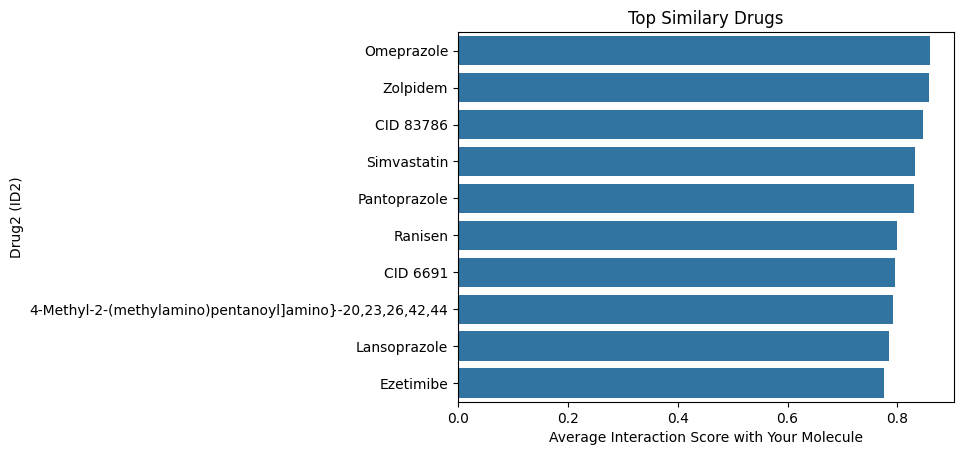

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_results = pd.DataFrame(interaction_results, columns=["Drug1", "Drug2", "Score", "SideEffect"])
top_id2s = df_results.groupby("Drug2")["Score"].mean().sort_values(ascending=False).head(10)

sns.barplot(x=top_id2s.values, y=top_id2s.index)
plt.xlabel("Average Interaction Score with Your Molecule")
plt.ylabel("Drug2 (ID2)")
plt.title("Top Similary Drugs")
# Save figure
plt.savefig('ApxFig1.png', dpi=300, bbox_inches='tight')
plt.show()

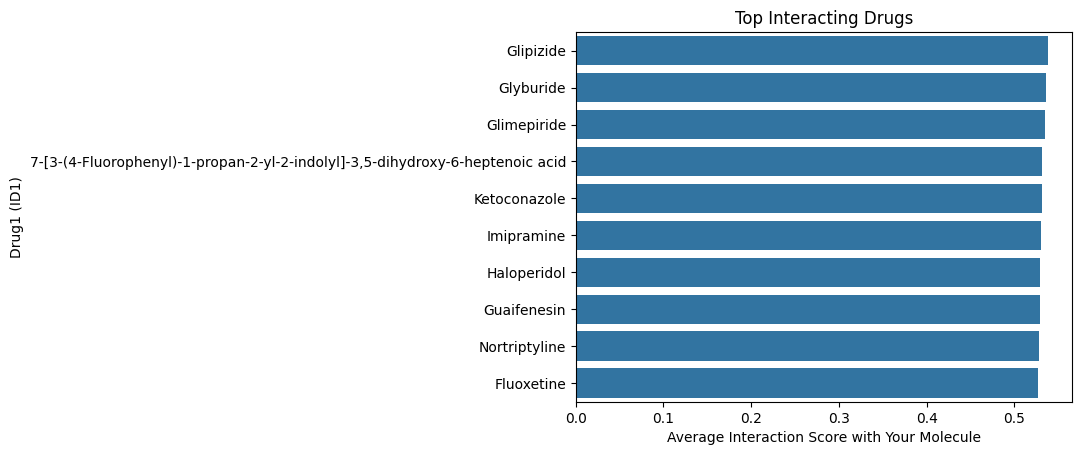

In [11]:
df_results = pd.DataFrame(interaction_results, columns=["Drug1", "Drug2", "Score", "SideEffect"])
top_id2s = df_results.groupby("Drug1")["Score"].mean().sort_values(ascending=False).head(10)

sns.barplot(x=top_id2s.values, y=top_id2s.index)
plt.xlabel("Average Interaction Score with Your Molecule")
plt.ylabel("Drug1 (ID1)")
plt.title("Top Interacting Drugs")
plt.savefig('ApxFig2.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
from collections import Counter

# Step 1: Filter high-score interactions
high_score_threshold = 0.8
high_score_pairs = [row for row in interaction_results if row[2] >= high_score_threshold]

# Step 2: Count side effects
side_effects = [row[3] for row in high_score_pairs if row[3]]
side_effect_counts = Counter(side_effects)

# Step 3: Display top 10 most common side effects
print("Top Side Effects in High-Score Interactions:")
for effect, count in side_effect_counts.most_common(10):
    print(f"{effect}: {count} times")

Top Side Effects in High-Score Interactions:
dysphonia: 696 times
Drug addiction: 515 times
respiratory failure: 482 times
insomnia: 310 times
rhinorrhea: 209 times
diverticulosis: 208 times
paranoia: 150 times
Decreased hearing: 149 times
bone spur: 136 times
Sjogrens syndrome: 130 times


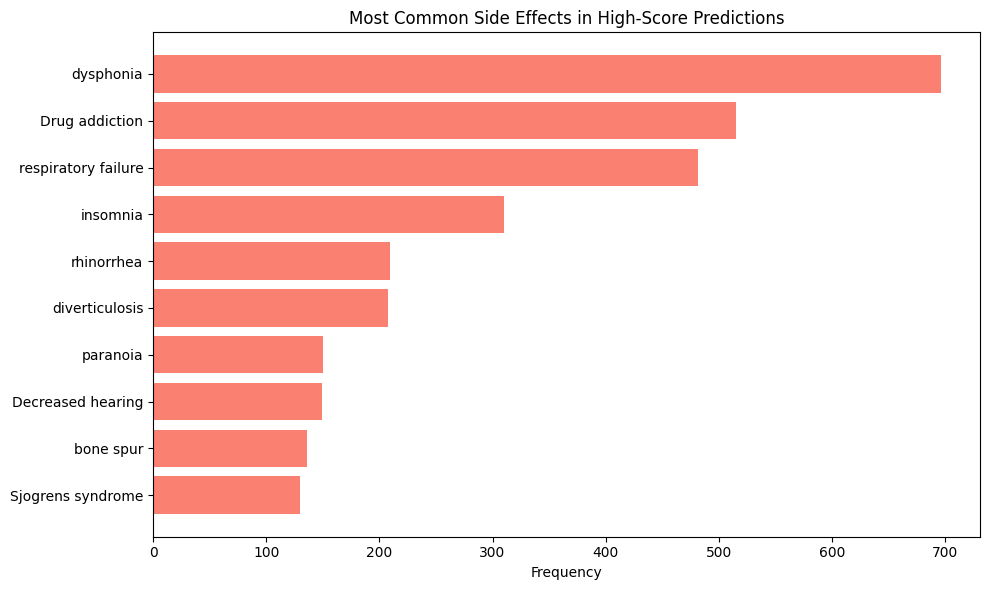

In [9]:
import matplotlib.pyplot as plt

top_effects = side_effect_counts.most_common(10)
effects, counts = zip(*top_effects)

plt.figure(figsize=(10, 6))
plt.barh(effects[::-1], counts[::-1], color='salmon')
plt.xlabel("Frequency")
plt.title("Most Common Side Effects in High-Score Predictions")
plt.tight_layout()
plt.savefig('ApxFig3.png', dpi=300)
plt.show()

[LightGBM] [Info] Number of positive: 50861, number of negative: 49338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.149904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12162
[LightGBM] [Info] Number of data points in the train set: 100199, number of used features: 4096
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507600 -> initscore=0.030402
[LightGBM] [Info] Start training from score 0.030402


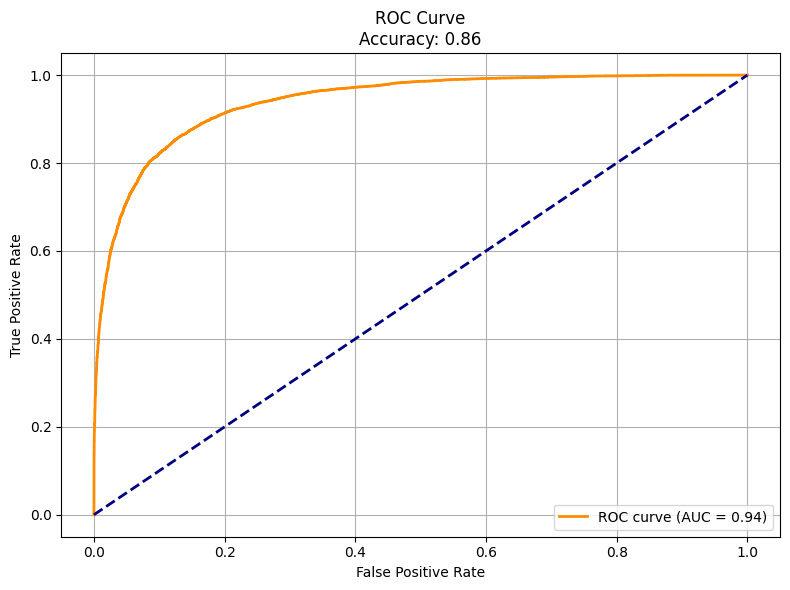

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

# Fit model
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# ROC curve values
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve\nAccuracy: {acc:.2f}')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# Save or show the plot
plt.savefig("roc_accuracy_plot.png", dpi=300)
plt.show()


C:\Users\bioha\AppData\Local\Temp\ipykernel_3116\1386468704.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




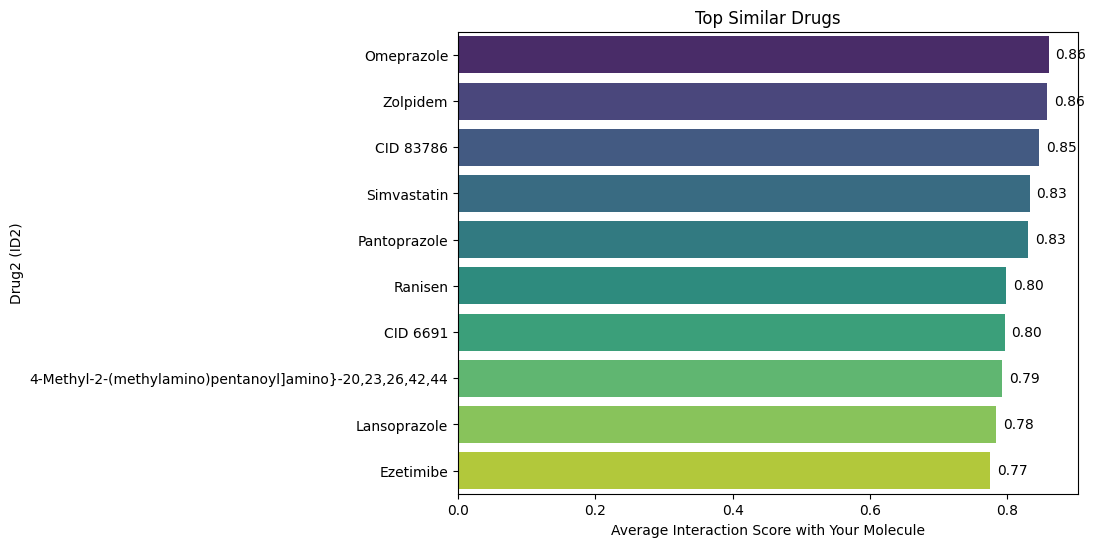

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame
df_results = pd.DataFrame(interaction_results, columns=["Drug1", "Drug2", "Score", "SideEffect"])
top_id2s = df_results.groupby("Drug2")["Score"].mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=top_id2s.values, y=top_id2s.index, palette="viridis")
plt.xlabel("Average Interaction Score with Your Molecule")
plt.ylabel("Drug2 (ID2)")
plt.title("Top Similar Drugs")

# Annotate values on bars
for i, (value, label) in enumerate(zip(top_id2s.values, top_id2s.index)):
    plt.text(value + 0.01, i, f"{value:.2f}", va='center')  # Shift slightly right and format to 2 decimals

# Save figure
plt.savefig('ApxFig4.png', dpi=300, bbox_inches='tight')
plt.show()
